# Assignment V: GitHub and the ticketmaster.com API

## General

GitHub repository: https://github.com/Borschu/Assignment_05

Import packages:

In [1]:
import numpy as np
import pandas as pd
import requests
import time

# install geopandas (for later task)
import sys
!{sys.executable} -m pip install geopandas

## Setting up a new GitHub repository

see link above

## Getting to know the API

### (5)

Rate limits:
- 5000 API calls per day
- 5 requests per second
- you can only retrieve the 1000 th item (size * page < 1000)


### (6)

In [2]:
# create connection to API key
with open("C:/Users/schur/OneDrive/Dokumente/Studium/Data Science Master Tübingen/1. Semester/Data Science Project Management/Assignment/key_assignment_5_python.py") as script:
  exec(script.readline())


## Interacting with the API - the basics

### (7)

In [3]:
# create content for venue = Germany
con_ven_ger = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey": ticketmaster_key, "countryCode": "DE"}).json()

# print content
print(con_ven_ger)

{'_embedded': {'venues': [{'name': 'Grosse Freiheit 36', 'type': 'venue', 'id': 'KovZpZAn6vEA', 'test': False, 'url': 'http://www.ticketmaster.de/venue/287636', 'locale': 'en-de', 'images': [{'ratio': '16_9', 'url': 'https://s1.ticketm.net/dbimages/962v.', 'width': 205, 'height': 115, 'fallback': False}], 'postalCode': '22767', 'timezone': 'Europe/Berlin', 'city': {'name': 'Hamburg'}, 'country': {'name': 'Germany', 'countryCode': 'DE'}, 'address': {'line1': 'Grosse Freiheit 36'}, 'location': {'longitude': '9.957905', 'latitude': '53.551187'}, 'markets': [{'name': 'Germany', 'id': '210'}], 'dmas': [{'id': 610}], 'boxOfficeInfo': {'phoneNumberDetail': 'Telefon tagsüber: (040) 31 77 78- 0 Große Freiheit 36 22767 Hamburg E-Mail: info@grossefreiheit36.de'}, 'upcomingEvents': {'_total': 1, 'mfx-de': 1, '_filtered': 0}, 'ada': {'adaPhones': '+49.(0)1805 - 969 0000 (14 Ct./Min.)', 'adaCustomCopy': 'Sollten Sie besondere Sitzplatzwünsche haben, prüfen Sie bitte die Informationsseite des Veranst

We can see different lists that are nested in each other. For each venue multiple attributes (name, type, id, test, url,…) exist. For some of the attributes a specific value is directly given (for example for name). Some of these attributes have another layer (for example location has a further layer for longitude / latitude). At the end of the printed output you an see some statistics about the request. For example that in total 238 pages or 4745 elements exist for this request. (As mentioned in the later task these 4745 elements are not all venues in Germany, because as default “locale” = “en” is set. If you change to “locale” = “*” you will get all venues (see task (9)))

### (8)

In [4]:
# define size of page
size = con_ven_ger['page']['size']

# create empty vectors for all characteristics
name = [None]*size
city = [None]*size
postalCode = [None]*size
address = [None]*size
url = [None]*size
longitude = [None]*size
latitude = [None]*size

# for loop over all list entries for every characteristic of the venue
for i in range(size):
    # If a list element doesnt exist a key error occurs and the loop stops.
    # To avoid this the try-except-structure is built
    # if a KeyError occurs the value is codes as NaN
    try:
        # get name for ith venue 
        name[i] = con_ven_ger['_embedded']['venues'][i]["name"]
    except KeyError:
        # if Key Error occurs then assign NaN
        name[i] = np.nan
    try:
        # get city for ith venue
        city[i] = con_ven_ger['_embedded']['venues'][i]["city"]['name']
    except KeyError:
        # if Key Error occurs then assign NaN
        city[i] = np.nan
    try:
        # get postalCode for ith venue
        postalCode[i] = con_ven_ger['_embedded']['venues'][i]["postalCode"]
    except KeyError:
        # if Key Error occurs then assign NaN
        postalCode[i] = np.nan
    try:
        # get address for ith venue
        address[i] = con_ven_ger['_embedded']['venues'][i]["address"]['line1']
    except KeyError:
        # if Key Error occurs then assign NaN
        address[i] = np.nan
    try:
        # get url for ith venue
        url[i] = con_ven_ger['_embedded']['venues'][i]["url"]
    except KeyError:
        # if Key Error occurs then assign NaN
        url[i] = np.nan
    try:
        # get longitude for ith venue
        longitude[i] = con_ven_ger['_embedded']['venues'][i]["location"]["longitude"]
    except KeyError:
        # if Key Error occurs then assign NaN
        longitude[i] = np.nan
    try:
        # get latitude for ith venue
        latitude[i] = con_ven_ger['_embedded']['venues'][i]["location"]["latitude"]
    except KeyError:
        # if Key Error occurs then assign NaN
        latitude[i] = np.nan
    
# create dataframe based on the previous created lists
df_venue_ger = pd.DataFrame({"name": name,
                           "city": city,
                           "postalCode": postalCode,
                           "address": address,
                           "url": url,
                           "longitude": longitude,
                           "latitude": latitude})

# print dataframe
print(df_venue_ger)


                             name             city postalCode  \
0              Grosse Freiheit 36          Hamburg      22767   
1                       Gruenspan          Hamburg      22767   
2               Huxleys Neue Welt           Berlin      10967   
3                   Virtual Event        Worldwide        NaN   
4           Ev. St. Jacobi Kirche     Sangerhausen      06526   
5             Evangelische Kirche           Senden      48308   
6                       HDI Arena         Hannover        NaN   
7                         Arsenal           Berlin      10785   
8       Freilichtbühne Heppenheim       Heppenheim      64646   
9                Schlosswallhalle        Osnabrück      49074   
10               Metropol Theater           Vechta      49377   
11        RÖDERMARK - Kulturhalle        Rödermark      63322   
12                           3922          Tambach      96479   
13                Nibelungenhalle         Walldürn      74731   
14            St. Johanni

## Interacting with the API - advanced

### (9)

In [5]:
# create a function to get all venues for a specific country
def create_df(countryCode):
    # create content 
    # we need to set "locale" = "*" because the default is "locale" = "en", with
    # this default we get only the 4745 venues for Germany. To get all venues we need to set
    # "locale" = "*"
    con = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey": ticketmaster_key, "countryCode": countryCode,
                                   "locale": "*"}).json()
    
    # let system sleep for 0.2 seconds because of the rate limits
    time.sleep(0.2)
    
    # get informations about the size of the page and the total nr of pages
    size = con['page']['size']
    nr_pages = con['page']['totalPages']
    
    # create None vectors
    name = [None]*1
    city = [None]*1
    postalCode = [None]*1
    address = [None]*1
    url = [None]*1
    longitude = [None]*1
    latitude = [None]*1
    
    # create a first dataframe (to this df the first dataframe that is created in the loop is added)
    df_all = pd.DataFrame({"name": name,
                                   "city": city,
                                   "postalCode": postalCode,
                                   "address": address,
                                   "url": url,
                                   "longitude": longitude,
                                   "latitude": latitude})
    
    # loop over all pages
    for p in range(nr_pages):
        # even if the system sleeps to comply with the rate limit, sometimes a key error occurs and the
        # request isnt succesfull. To prevent this this try except structure is build so if the request
        # isnt succesfull request again
        try: 
            # get request for a specific page of a specific countryCode (also set "locale": "*" to get all venues)
            con = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                              params = {"apikey": ticketmaster_key, "countryCode": countryCode, "page": p,
                                       "locale": "*"}).json()
        except KeyError: 
            con = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                              params = {"apikey": ticketmaster_key, "countryCode": countryCode, "page": p,
                                       "locale": "*"}).json()
        
        # this condition is needed for last page
        # often the last page isn't full so the size is adjusted to the nr of venues on the last page
        if p == nr_pages-1:
            size = (con['page']['totalElements'] % size)
        
        # create empty vectors (lenght = nr of elements on a page) for all characteristics
        name = [None]*size
        city = [None]*size
        postalCode = [None]*size
        address = [None]*size
        url = [None]*size
        longitude = [None]*size
        latitude = [None]*size

        # for loop over all list entries for every characteristic of the venue
        for i in range(size):
            # If a list element doesnt exist a key error occurs and the loop stops.
            # To avoid this the try-except-structure is built
            # if a KeyError occurs the value is codes as NaN
            try:
                # get name for ith venue 
                name[i] = con['_embedded']['venues'][i]["name"]
            except KeyError:
                # if Key Error occurs then assign NaN
                name[i] = np.nan
            try:
                city[i] = con['_embedded']['venues'][i]["city"]['name']
            except KeyError:
                city[i] = np.nan
            try:
                postalCode[i] = con['_embedded']['venues'][i]["postalCode"]
            except KeyError:
                postalCode[i] = np.nan
            try:
                address[i] = con['_embedded']['venues'][i]["address"]['line1']
            except KeyError:
                address[i] = np.nan
            try:
                url[i] = con['_embedded']['venues'][i]["url"]
            except KeyError:
                url[i] = np.nan
            try:
                longitude[i] = con['_embedded']['venues'][i]["location"]["longitude"]
            except KeyError:
                longitude[i] = np.nan
            try:
                latitude[i] = con['_embedded']['venues'][i]["location"]["latitude"]
            except KeyError:
                latitude[i] = np.nan

        # create dataframe based on the previous created lists
        df_venue = pd.DataFrame({"name": name,
                                   "city": city,
                                   "postalCode": postalCode,
                                   "address": address,
                                   "url": url,
                                   "longitude": longitude,
                                   "latitude": latitude})
        
        # add the new dataframe tu df_all (the first df_all is created befor looping over the different pages)
        df_all = pd.concat([df_all,df_venue])
        
        # pause because of the rate limits
        time.sleep(0.2)
        
    # drop first rows with Nones (because in the beginnen a dataframe with a rows of None is created)
    df_all = df_all.iloc[1:]
    
    # change datatype of columns longitude, latitude
    df_all["longitude"] = pd.to_numeric(df_all["longitude"])
    df_all["latitude"] = pd.to_numeric(df_all["latitude"])
    
    #return created dataframe
    return df_all

# create Dataframe for Germany
df_ger = create_df("DE")

# print first 10 rows of Dataframe
print("First 10 rows: ")
print(df_ger.head(10))

# print shape of dataframe
print("The dataframe has the following shape: ")
print(df_ger.shape)

First 10 rows: 
                       name          city postalCode                address  \
0        Grosse Freiheit 36       Hamburg      22767     Grosse Freiheit 36   
1                 Gruenspan       Hamburg      22767     Grosse Freiheit 58   
2         Huxleys Neue Welt        Berlin      10967   Hasenheide 107 – 113   
3           Zentrum am Park  Emmelshausen      56281  Rhein-Mosel-Straße 45   
4  Stadthalle (Theatersaal)       Mülheim      45479  Theodor-Heuss-Platz 1   
5             Schlossgarten      Bruchsal      76646       Schloss Bruchsal   
6                Stadthalle    Hockenheim      68766        Rathausstraße 3   
7                       FZW      Dortmund      44263        Ritterstraße 20   
8               Arena Trier         Trier      54292     Fort-Worth-Platz 1   
9             Eissporthalle     Memmingen      87700    Hühnerbergstraße 19   

                                                 url  longitude   latitude  
0            http://www.ticketmaster.

## Visualizing the extracted data


### (10)

<AxesSubplot:>

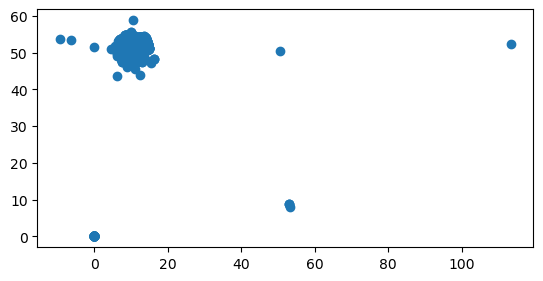

In [6]:
# import package
import geopandas as gpd

# create GeoDataFrame with special column for longitude / latitude
df_ger_geo = gpd.GeoDataFrame(
    df_ger, geometry = gpd.points_from_xy(df_ger.longitude,df_ger.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_ger_geo.plot(ax = map)


### (11)

<AxesSubplot:>

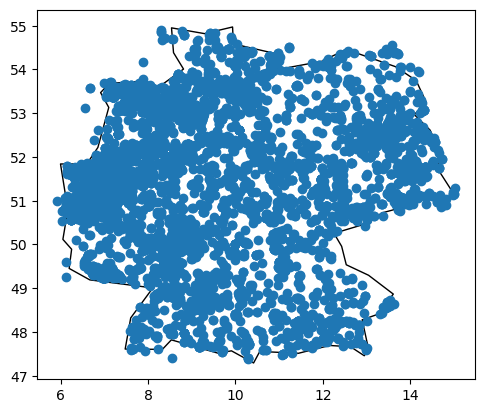

In [7]:
# write a function to adjust the longitude / latitude
# if these values aren't within the specific range for the country -> coded as NA
def adjust_long_lat(df,long_low,long_up,lat_low,lat_up):
    df.loc[df["longitude"] <long_low, "longitude"] = np.nan
    df.loc[df["longitude"] >long_up, "longitude"] = np.nan
    df.loc[df["latitude"] <lat_low, "latitude"] = np.nan
    df.loc[df["latitude"] >lat_up, "latitude"] = np.nan
    # return adjusted dataframe
    return df

# adjust the coordinates in case they outside of the longitude / latitude range
df_ger = adjust_long_lat(df_ger,5.866, 15.042, 47.270, 55.059)

# create GeoDataFrame 
df_ger_geo = gpd.GeoDataFrame(
    df_ger, geometry = gpd.points_from_xy(df_ger.longitude,df_ger.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_ger_geo.plot(ax = map)

### Event locations in other countries

### (12)

First 10 rows: 
                          name             city postalCode  \
0                    Live Club            Milan      20056   
1                        ITALY  Gardone Riviera      25083   
2                        ITALY           Rubano      35030   
3                        ITALY             Rome      00187   
4                        ITALY           Modena      41121   
5                        ITALY           Rivoli      10098   
6  Teatro Nazionale CheBanca!            Milano      20149   
7                Visarno Arena         Florence      50144   
8                   Stadthalle            Bozen      39100   
9              Arena di Verona           Verona      37121   

                                    address  \
0                  Via Giuseppe Mazzini, 58   
1                     Corso Zanardelli, 196   
2         via Liguria 1  Sarmeola di Rubano   
3                         Via del babuino 9   
4                             Via Stella 22   
5  Piazza Mafalda d

<AxesSubplot:>

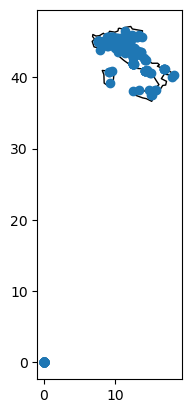

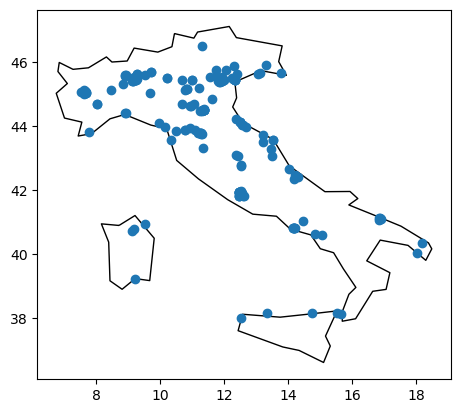

In [8]:
# create Dataframe for Italy
df_it = create_df("IT")

# print first 10 rows of Dataframe
print("First 10 rows: ")
print(df_it.head(10))

# print shape of dataframe
print("The dataframe has the following shape: ")
print(df_it.shape)


# create GeoDataFrame based on the
df_it_geo = gpd.GeoDataFrame(
    df_it, geometry = gpd.points_from_xy(df_it.longitude,df_it.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Italy"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_it_geo.plot(ax = map)

# adjust the coordinates based on the extreme coordinates are for Italy
df_it = adjust_long_lat(df_it,6.616667, 18.516667, 37.933333, 47.083333)

# Updated version of the graph
# create GeoDataFrame based on the
df_it_geo = gpd.GeoDataFrame(
    df_it, geometry = gpd.points_from_xy(df_it.longitude,df_it.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Italy"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_it_geo.plot(ax = map)